,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


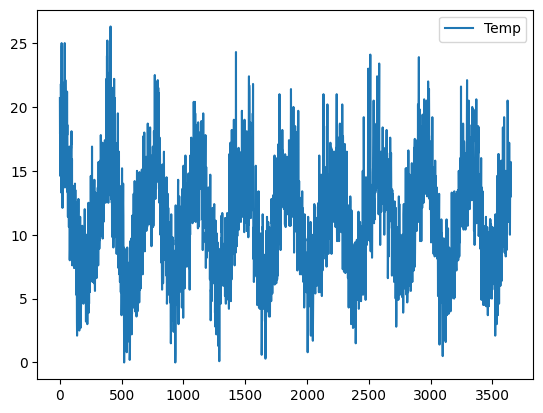

In [3]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Colab-TimeSeriesBasics/daily-min-temperatures.csv')
df.plot()
df.head(10)

In [4]:
df['Temp_1DayBack'] = df['Temp'].shift(+1)
df['Temp_2DaysBack'] = df['Temp'].shift(+2)
df['Temp_3DaysBack'] = df['Temp'].shift(+3)
df['Temp_4DaysBack'] = df['Temp'].shift(+4)
df['Temp_5DaysBack'] = df['Temp'].shift(+5)
df['Temp_6DaysBack'] = df['Temp'].shift(+6)
df['Temp_7DaysBack'] = df['Temp'].shift(+7)
df.head(10)

,Date,Temp,Temp_1DayBack,Temp_2DaysBack,Temp_3DaysBack,Temp_4DaysBack,Temp_5DaysBack,Temp_6DaysBack,Temp_7DaysBack
0,1981-01-01,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-02,17.9,20.7,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-03,18.8,17.9,20.7,NaN,NaN,NaN,NaN,NaN
3,1981-01-04,14.6,18.8,17.9,20.7,NaN,NaN,NaN,NaN
4,1981-01-05,15.8,14.6,18.8,17.9,20.7,NaN,NaN,NaN
5,1981-01-06,15.8,15.8,14.6,18.8,17.9,20.7,NaN,NaN
6,1981-01-07,15.8,15.8,15.8,14.6,18.8,17.9,20.7,NaN
7,1981-01-08,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
8,1981-01-09,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
9,1981-01-10,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8


In [5]:
df = df.dropna()
df.head(10)

,Date,Temp,Temp_1DayBack,Temp_2DaysBack,Temp_3DaysBack,Temp_4DaysBack,Temp_5DaysBack,Temp_6DaysBack,Temp_7DaysBack
7,1981-01-08,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
8,1981-01-09,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
9,1981-01-10,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8
10,1981-01-11,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6
11,1981-01-12,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8
12,1981-01-13,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8
13,1981-01-14,21.5,16.7,13.3,16.2,20.0,21.8,17.4,15.8
14,1981-01-15,25.0,21.5,16.7,13.3,16.2,20.0,21.8,17.4
15,1981-01-16,20.7,25.0,21.5,16.7,13.3,16.2,20.0,21.8
16,1981-01-17,20.6,20.7,25.0,21.5,16.7,13.3,16.2,20.0


In [6]:
# Make training data X
X = df.drop(['Date','Temp'],axis=1).copy()
X.head(10)

,Temp_1DayBack,Temp_2DaysBack,Temp_3DaysBack,Temp_4DaysBack,Temp_5DaysBack,Temp_6DaysBack,Temp_7DaysBack
7,15.8,15.8,15.8,14.6,18.8,17.9,20.7
8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
9,21.8,17.4,15.8,15.8,15.8,14.6,18.8
10,20.0,21.8,17.4,15.8,15.8,15.8,14.6
11,16.2,20.0,21.8,17.4,15.8,15.8,15.8
12,13.3,16.2,20.0,21.8,17.4,15.8,15.8
13,16.7,13.3,16.2,20.0,21.8,17.4,15.8
14,21.5,16.7,13.3,16.2,20.0,21.8,17.4
15,25.0,21.5,16.7,13.3,16.2,20.0,21.8
16,20.7,25.0,21.5,16.7,13.3,16.2,20.0


In [7]:
# Make training label y
y = df['Temp'].copy()
y.head(10)

7     17.4
8     21.8
9     20.0
10    16.2
11    13.3
12    16.7
13    21.5
14    25.0
15    20.7
16    20.6
Name: Temp, dtype: float64

In [8]:
# Divide train and test set
pred_length = 50
X_train, X_test = X[:len(X)-pred_length], X[len(X)-pred_length:]
y_train, y_test = y[:len(y)-pred_length], y[len(y)-pred_length:]
X_test.head(10)

,Temp_1DayBack,Temp_2DaysBack,Temp_3DaysBack,Temp_4DaysBack,Temp_5DaysBack,Temp_6DaysBack,Temp_7DaysBack
3600,8.6,11.5,13.1,15.4,19.2,18.3,12.5
3601,12.6,8.6,11.5,13.1,15.4,19.2,18.3
3602,13.8,12.6,8.6,11.5,13.1,15.4,19.2
3603,14.6,13.8,12.6,8.6,11.5,13.1,15.4
3604,13.2,14.6,13.8,12.6,8.6,11.5,13.1
3605,12.3,13.2,14.6,13.8,12.6,8.6,11.5
3606,8.8,12.3,13.2,14.6,13.8,12.6,8.6
3607,10.7,8.8,12.3,13.2,14.6,13.8,12.6
3608,9.9,10.7,8.8,12.3,13.2,14.6,13.8
3609,8.3,9.9,10.7,8.8,12.3,13.2,14.6


In [9]:
# Reset test set index
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test.head(10)

,Temp_1DayBack,Temp_2DaysBack,Temp_3DaysBack,Temp_4DaysBack,Temp_5DaysBack,Temp_6DaysBack,Temp_7DaysBack
0,8.6,11.5,13.1,15.4,19.2,18.3,12.5
1,12.6,8.6,11.5,13.1,15.4,19.2,18.3
2,13.8,12.6,8.6,11.5,13.1,15.4,19.2
3,14.6,13.8,12.6,8.6,11.5,13.1,15.4
4,13.2,14.6,13.8,12.6,8.6,11.5,13.1
5,12.3,13.2,14.6,13.8,12.6,8.6,11.5
6,8.8,12.3,13.2,14.6,13.8,12.6,8.6
7,10.7,8.8,12.3,13.2,14.6,13.8,12.6
8,9.9,10.7,8.8,12.3,13.2,14.6,13.8
9,8.3,9.9,10.7,8.8,12.3,13.2,14.6


In [10]:
# Train XGBoost and test
model_xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=30)
model_xgbr.fit(X_train, y_train, verbose=True, eval_set=[(X_test,y_test)])
y_pred = model_xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

[0]	validation_0-rmse:2.80791
[1]	validation_0-rmse:2.51616
[2]	validation_0-rmse:2.29498
[3]	validation_0-rmse:2.19717
[4]	validation_0-rmse:2.17103
[5]	validation_0-rmse:2.18522
[6]	validation_0-rmse:2.17344
[7]	validation_0-rmse:2.19424
[8]	validation_0-rmse:2.20271
[9]	validation_0-rmse:2.20559
[10]	validation_0-rmse:2.21844
[11]	validation_0-rmse:2.23760
[12]	validation_0-rmse:2.25000
[13]	validation_0-rmse:2.26409
[14]	validation_0-rmse:2.23476
[15]	validation_0-rmse:2.23454
[16]	validation_0-rmse:2.23845
[17]	validation_0-rmse:2.24038
[18]	validation_0-rmse:2.24047
[19]	validation_0-rmse:2.25004
[20]	validation_0-rmse:2.24865
[21]	validation_0-rmse:2.24446
[22]	validation_0-rmse:2.25300
[23]	validation_0-rmse:2.25303
[24]	validation_0-rmse:2.26254
[25]	validation_0-rmse:2.26394
[26]	validation_0-rmse:2.26408
[27]	validation_0-rmse:2.26583
[28]	validation_0-rmse:2.27196
[29]	validation_0-rmse:2.27214
MSE:  5.162638580347027
RMSE:  2.272144049207054


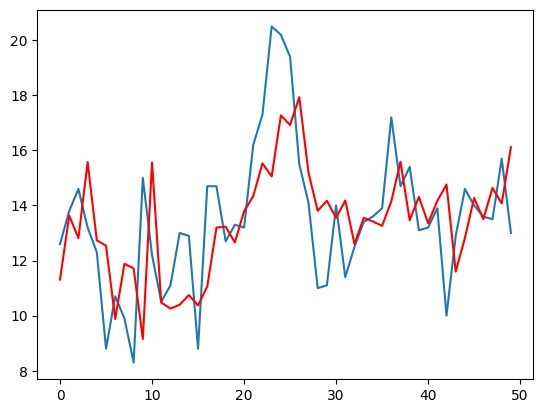

In [11]:
plt.plot(y_test)
plt.plot(y_pred, color='red')
plt.show()